# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.3.1'

#### Load Image Data

In [45]:
DATA_LIST = os.listdir('two/train')
DATASET_PATH  = 'two/train'
TEST_DIR =  'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [10]:
VGG16 = tf.keras.applications.VGG16(weights="imagenet", include_top = False, input_shape = (224, 224, 3))

VGG16.trainable = False

model = tf.keras.Sequential([
    VGG16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', name='dense_feature'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_feature (Dense)        (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


#### [5 points] Train Model

In [11]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

#need to specify step size
history = model.fit(train_batches, batch_size=BATCH_SIZE, steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs=NUM_EPOCHS, validation_data=valid_batches, validation_steps=STEP_SIZE_VALID)

11
3
Epoch 1/40
10/10 [==============================] - 20s 2s/step - loss: 2.2660 - accuracy: 0.4362 - val_loss: 0.6367 - val_accuracy: 0.5500
Epoch 2/40
10/10 [==============================] - 20s 2s/step - loss: 0.5374 - accuracy: 0.7766 - val_loss: 0.4125 - val_accuracy: 1.0000
Epoch 3/40
10/10 [==============================] - 20s 2s/step - loss: 0.4139 - accuracy: 0.8191 - val_loss: 0.3330 - val_accuracy: 0.9000
Epoch 4/40
10/10 [==============================] - 22s 2s/step - loss: 0.3749 - accuracy: 0.8511 - val_loss: 0.3103 - val_accuracy: 0.9000
Epoch 5/40
10/10 [==============================] - 21s 2s/step - loss: 0.2895 - accuracy: 0.9149 - val_loss: 0.2533 - val_accuracy: 0.9500
Epoch 6/40
10/10 [==============================] - 20s 2s/step - loss: 0.2515 - accuracy: 0.9043 - val_loss: 0.1713 - val_accuracy: 1.0000
Epoch 7/40
10/10 [==============================] - 20s 2s/step - loss: 0.2754 - accuracy: 0.8723 - val_loss: 0.1716 - val_accuracy: 1.0000
Epoch 8/40
10/1

#### [5 points] Plot Accuracy and Loss During Training

Text(0.5, 1.0, 'Accuracy over 40 epochs')

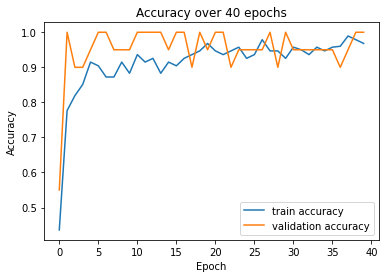

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy over ' + str(NUM_EPOCHS) + ' epochs')

Text(0.5, 1.0, 'Loss over 40 epochs')

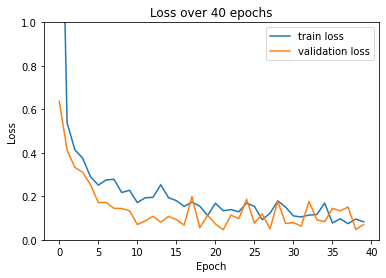

In [81]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Loss over ' + str(NUM_EPOCHS) + ' epochs')
#print(str(history.history['loss']))

#### Plot Test Results

Found 18 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
18/18 [==============================] - 4s 203ms/step
covid/nejmoa2001191_f3-PA.jpeg


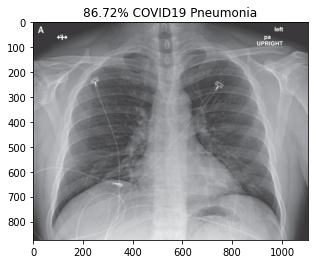

covid/nejmoa2001191_f4.jpeg


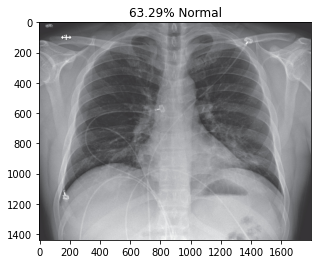

covid/nejmoa2001191_f5-PA.jpeg


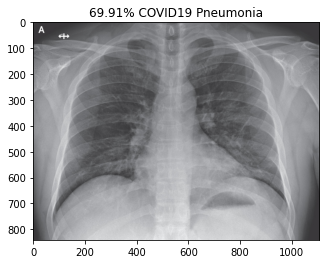

covid/radiol.2020200490.fig3.jpeg


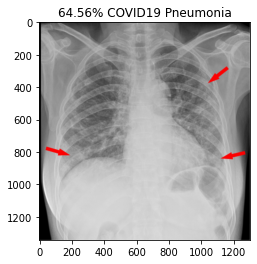

covid/ryct.2020200028.fig1a.jpeg


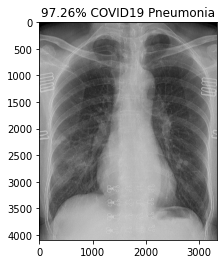

covid/ryct.2020200034.fig2.jpeg


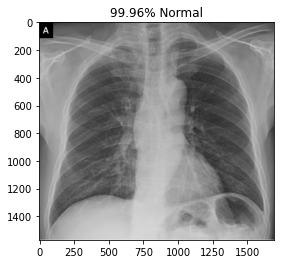

covid/ryct.2020200034.fig5-day0.jpeg


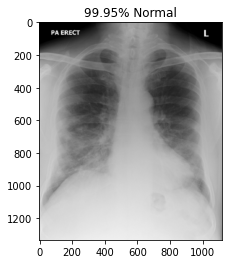

covid/ryct.2020200034.fig5-day4.jpeg


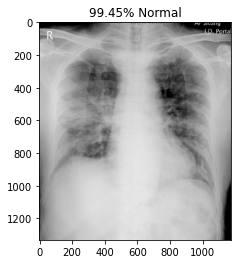

covid/ryct.2020200034.fig5-day7.jpeg


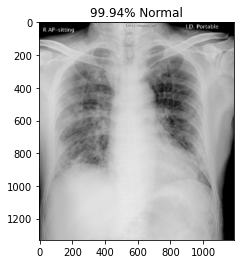

normal/NORMAL2-IM-1385-0001.jpeg


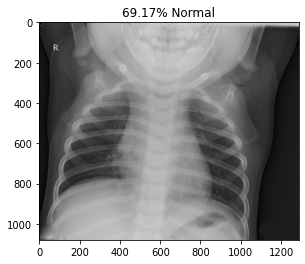

normal/NORMAL2-IM-1396-0001.jpeg


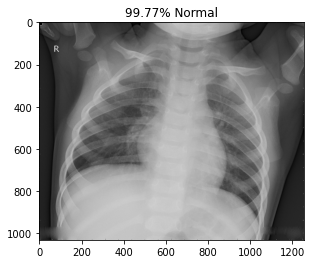

normal/NORMAL2-IM-1400-0001.jpeg


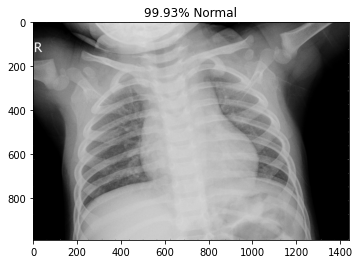

normal/NORMAL2-IM-1401-0001.jpeg


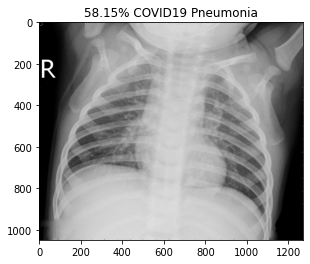

normal/NORMAL2-IM-1406-0001.jpeg


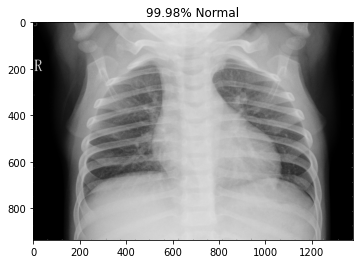

normal/NORMAL2-IM-1412-0001.jpeg


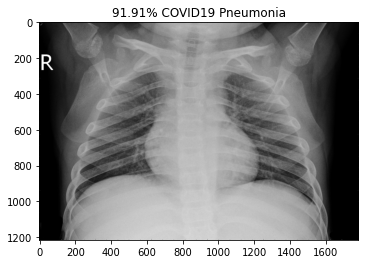

normal/NORMAL2-IM-1419-0001.jpeg


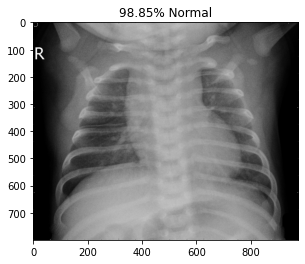

normal/NORMAL2-IM-1422-0001.jpeg


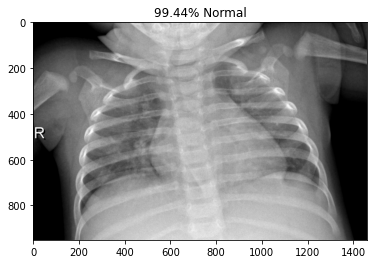

normal/NORMAL2-IM-1423-0001.jpeg


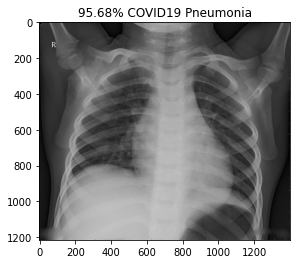

In [17]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.

LEGEND:
blue = Normal
red = Covid


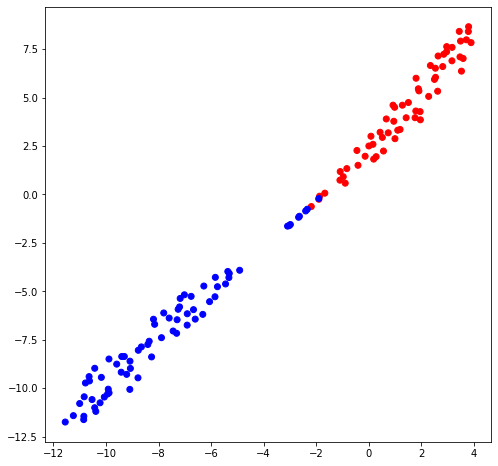

In [89]:
from sklearn.manifold import TSNE
from tensorflow.keras import models

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_feature').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False, class_mode="binary")

# print(train_batches.labels)

# print(valid_batches.labels)

# print((len(train_batches.labels) + len(valid_batches.labels)))

# print(tsne_data_generator.labels)

#print(str(model.output[0]))
# print("intermediate layer model: ")
# print(intermediate_layer_model.input.shape)
# print(intermediate_layer_model.output.shape)

layer = intermediate_layer_model.predict(tsne_data_generator)

# (COMMENTED OUT)
# print(pred.shape)
# print(layer.shape)
# print(tsne_data_generator[1])
# print(pred)
# print(str(layer[0][0]))
# print(len(layer))

labels = tsne_data_generator.labels
tsne = TSNE(n_components=2)
intermediate_tsne = tsne.fit_transform(layer)

# print("Len of TSNE: " + str(len(intermediate_tsne)))

color_array = []
for i in range(len(labels)):
    if labels[i] > 0.5:
        color_array += 'b'
    else:
        color_array += 'r'
        
# print(pred)
# print(color_array)
print("\nLEGEND:")
print("blue = Normal")
print("red = Covid")

plt.figure(figsize=(8, 8))
plt.scatter(x = intermediate_tsne[:,0], y=intermediate_tsne[:,1], c=color_array)
plt.show()
# print("OK")

# <!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->